# Checking_GPU_Availabilty

In [1]:
import torch
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# CMD Tensorboard

### tensorboard --logdir="C:\Users\User\OneDrive - University College London\UCL Education\Year 4\MLS\Coursework\AMLS_assignment24_25\Task A\runs\DisplayImage"

# Library imports, data loading and visualisation


In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import medmnist
from medmnist import BreastMNIST
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import os
import shutil

import os
from tensorboard import program

import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch import optim  # For optimizers like SGD, Adam, etc.
from tqdm import tqdm  # For nice progress bar!
import torchvision.datasets as datasets  # Standard datasets

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

## Loading datatsets from BreastMNIST

In [4]:
transform = transforms.Compose([
    # transforms.RandomAdjustSharpness(p=1,sharpness_factor=1.1),
    # transforms.RandomEqualize(p=0.3),
    # transforms.RandomVerticalFlip(p=0.1),
    # transforms.RandomHorizontalFlip(p=0.1),
    #transforms.Pad(padding=98, fill=0),  # Zero padding to make the image 224x224
    #transforms.Pad(padding=50, fill=0),  # Add zero padding to make 128x128
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Mean and standard deviation for grayscale images
])
#Cannot blindly augment the data to what we want
#the classifiers depend on the chape of the tumer hence all the below is good
#Might consider increaasing the contrast and brightness to allow easier identificationn
#CANCEL contrast... USE histogram equaliser instetad
transforms.RandomVerticalFlip()
transforms.RandomHorizontalFlip()
transforms.RandomRotation(degrees=180)
transforms.RandomEqualize(p=1)
transforms.RandomAdjustSharpness(p=1,sharpness_factor=2)

RandomAdjustSharpness(sharpness_factor=2,p=1)

In [5]:
batch_size=64
#loading train,val,test into variables
train_data=medmnist.BreastMNIST(split="train",transform=transform)
val_data=medmnist.BreastMNIST(split="val",transform=transforms.ToTensor())
test_data=medmnist.BreastMNIST(split="test",transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)


# Data augmentation and class balancing

In [224]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter



# Instantiate the dataset
dataset = medmnist.BreastMNIST(split="train",transform=transform)

# Count class occurrences
class_counts = Counter(dataset.labels.reshape(-1))
print(f"Class distribution before oversampling: {class_counts}")

# Compute sample weights: Inverse of class frequencies
class_weights = 1.0 / torch.tensor([class_counts[cls] for cls in sorted(class_counts.keys())], dtype=torch.float)
sample_weights = torch.tensor([class_weights[label] for label in dataset.labels.reshape(-1)], dtype=torch.float)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader with sampler
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
train_data=dataloader
# Check the distribution of classes in a few batches
for batch_idx, (data, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx+1} class distribution: {Counter(labels.reshape(-1).tolist())}")
    if batch_idx == 2:  # Check only the first 3 batches
        break

# Initialize a Counter for tracking class counts
total_class_counts = Counter()

# Iterate through the entire dataloader
for data, labels in dataloader:
    # Flatten the labels and convert them to a list
    total_class_counts.update(labels.reshape(-1).tolist())

# Print the total distribution of classes
print(f"Total class distribution in the dataloader: {total_class_counts}")
print(len(dataloader)*32)

Class distribution before oversampling: Counter({1: 399, 0: 147})
Batch 1 class distribution: Counter({0: 17, 1: 15})
Batch 2 class distribution: Counter({0: 17, 1: 15})
Batch 3 class distribution: Counter({0: 19, 1: 13})
Total class distribution in the dataloader: Counter({1: 299, 0: 247})
576


In [87]:
data, labels=next(iter(train_loader))
x=labels.view(-1)
x=x.tolist()
print(x)
Counter(x)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


Counter({1: 52, 0: 12})

# Loading Example mnist dataset

In [8]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

# Load Data
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Debugging and testing

In [8]:

# print(train_data)
# print("=====================")
# print(val_data)
# print("=====================")
# print(test_data)

for i, (images, labels) in enumerate(train_loader):
    print(images.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

In [43]:
#visualising the size of the image and its labels
one=0
zero=0
for image , label in train_data:
    # print(image.shape)
    # print(label)
    if label==0:
        zero+=1
    else:
        one+=1
print(one)
print(zero)

399
147


### Displaying images on Tensorboard

In [11]:
#location of tensorboard folder
folder="runs/DisplayImage"

In [164]:
clear_folder(folder)
#show using dataset on tensorboard
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
writer = SummaryWriter(f"runs/DisplayImage")
for index in range(100):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)
    
writer.close()

Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733867044.DESKTOP-3FC1MTH.29016.68
All contents of the folder 'runs/DisplayImage' have been cleared.


In [150]:
clear_folder(folder)
#show using dataloader with batches
for batch_idx, (data, targets) in enumerate(train_loader):
    # create grid of images
    img_grid = torchvision.utils.make_grid(data)
    # write to tensorboard
    writer.add_image(f"MNIST Example - image batch ", img_grid,batch_idx)
    #print(batch_idx)
writer.close

Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733866663.DESKTOP-3FC1MTH.29016.63
All contents of the folder 'runs/DisplayImage' have been cleared.


<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x0000022A861F86A0>>

### Displaying image

torch.Size([28, 28])


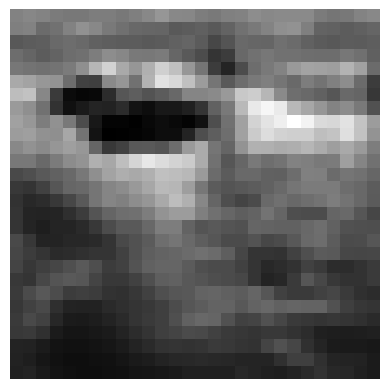

In [27]:
img,label = train_data[1]
image_np = img.squeeze()
print(image_np.shape)
# Plot the image
plt.imshow(image_np,cmap="gray")
plt.axis('off')  # Hide the axes for better visualization
plt.show()

# Functions

## Check GPU

In [6]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'NVIDIA GeForce GTX 1650'

In [8]:

# Function to copy tensor files save
def copy_directory(source_dir, destination_dir):
    """
    Copies all files and folders from a source directory to a destination directory.

    Args:
        source_dir (str): The path to the source directory.
        destination_dir (str): The path to the existing destination directory.
    """
    try:
        # Ensure the destination directory exists
        if not os.path.isdir(destination_dir):
            print(f"Error: Destination directory '{destination_dir}' does not exist.")
            return

        # Copy the content of source dir to destination directory
        shutil.copytree(source_dir, os.path.join(destination_dir, os.path.basename(source_dir)))
        print(f"Successfully copied the content of '{source_dir}' to '{destination_dir}'")

    except FileNotFoundError:
        print(f"Error: Source directory '{source_dir}' not found.")
    except shutil.Error as e:
        print(f"Error during copy: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")



#function to clear tensorboard files

def clear_folder(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return
    
    # Iterate through all items in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        try:
            # Remove directories
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
            # Remove files
            else:
                os.remove(item_path)
            print(f"Deleted: {item_path}")
        except Exception as e:
            print(f"Failed to delete {item_path}: {e}")
    
    print(f"All contents of the folder '{folder_path}' have been cleared.")
    #location of tensorboard folder
folder="runs/DisplayImage"


class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 2 (0-1)

        """
        super(NN, self).__init__()
        # # Our first linear layer take input_size, in this case 784 nodes to 50
        # # and our second linear layer takes 50 to the num_classes we have, in
        # # this case 10.
        # self.fc1 = nn.Linear(input_size, 50)
        # self.fc2 = nn.Linear(50, num_classes)

        self.flatten = nn.Flatten() #flattens the input tensors
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
            # nn.ReLU(),
            # nn.Linear(512, 2)
        )

    def forward(self, x):
        """
        x here is the mnist images and we run it through the network that we created above.
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(  #same convolution
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16, 
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

class NN2(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)

        """
        super(NN2, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.flatten = nn.Flatten() #flattens the input tensors
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)

        Parameters:
            x: mnist images

        Returns:
            out: the output of the network
        """
        x=self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    accuracies=[]
    batch_loss=0
    for batch, (input_data, class_cat) in enumerate(tqdm(dataloader)):
        input_data, class_cat = input_data.to(device), class_cat.to(device)

        ## Compute prediction error
        pred = model(input_data)
        class_cat=class_cat.squeeze().long()
        loss = loss_fn(pred, class_cat)

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        ## calculation running loss
        loss, current = loss.item(), (batch + 1) * len(input_data)


        ##caculating running accuracy
        _, predictions = pred.max(1)
        num_correct = (predictions == class_cat).sum()
        running_train_acc = float(num_correct) / float(input_data.shape[0])
        # print("model Output>>>>>")
        # print(pred)
        # print("predictions>>>")
        # print(predictions)
        # print("num_correct>>>>>")
        # print(num_correct)
        # print("accuracy>>>>")
        # print(running_train_acc)
        # print(data.shape[0])
        # print(input_data.shape[0])
        accuracies.append(running_train_acc)

        ##Plot stuff to tensorboard tensorboard
        global step
        writer.add_scalar("Batch/Training loss",loss,global_step=step)
        writer.add_scalar("Batch/Training Accuracy", running_train_acc, global_step=step)
        # global batch_loss
        # batch_loss.append(loss)
        batch_loss+=loss

        
        step += 1


        #print(f"loss: {loss:>7f} accuracy: {running_train_acc:>5f}  [{current:>5d}/{size:>5d}]")
    
    ## Calculate epoch accuracy
    epoch_accuracy=sum(accuracies)/len(accuracies)

    ## Getting the average epoch loss
    epoch_loss=batch_loss/size
    
    ## Send it to tensorboard
    writer.add_scalars("Epoch/Epoch loss",{'Train':epoch_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Train":epoch_accuracy},global_step=epoch)
    
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y=y.squeeze().long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    writer.add_scalars("Epoch/Epoch loss",{'Val':test_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Val":correct},global_step=epoch)
    print(f"val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    val_acc=correct
    # Save the model if it's the best so far
    global best_val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_weights.pth")
        print(f"New best model saved with accuracy: {best_val_acc:.4f}")
        # Log accuracy to TensorBoard
        writer.add_scalar("Val Accuracy", correct,global_step=1)



def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.squeeze().long()
            pred = model(X)
            # Collect predictions and true labels
            all_labels.append(int(y))
            all_predictions.append(int(pred.argmax(1)))
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate accuracy
    correct /= size

    # Build confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_names = ["False", "Positive"]  # Update as needed for your use case

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()  # Ensure labels fit within figure boundaries
    

    # Convert plot to image
    fig = plt.gcf()
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    plt.show()
    plt.close(fig)  # Close figure to free memory

    # Log image to 
    writer.add_image("Confusion Matrix", np.transpose(image, (2, 0, 1)),global_step=1)
 
    # Log accuracy to TensorBoard
    writer.add_scalar("Test Accuracy", correct,global_step=1)

    # Print accuracy
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%\n")

print("Done")

def savemodel(model_name,model,tensor_path):

    #Create folder for new model in saved model
    try:
        os.mkdir(f"Saved_models/{model_name}") # Will not create parent folders, unlike os.makedirs()
        print(f"Folder created successfully")
    except OSError as e:
        print(f"Error creating folder: {e}")

    #Copy tensorboard data of the session to     
    tensorpath="runs\DisplayImage"
    copy_directory(tensorpath,f"Saved_models/{model_name}")

    # 7. Save entire model (Less recommended).
    save_entire_model_path = f"Saved_models/{model_name}/{model_name}.pth"
    torch.save(model, save_entire_model_path)
    print(f"Entire model saved to: {save_entire_model_path}")   


Done


In [27]:
#basinc testing for the model
model=CNN()
x=torch.randn(20,1,28,28)
print(model(x).shape)

model=NN(input_size=28*28,num_classes=2)
x=torch.randn(20,1,28,28)
print(model(x).shape)

torch.Size([20, 10])
torch.Size([20, 10])


# Fully connected network


NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Val: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Val'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Val: [WinError 5] Access is denied:

100%|██████████| 9/9 [00:00<00:00, 90.11it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.614405 

New best model saved with accuracy: 0.7308
Epoch 2
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.18it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.555694 

Epoch 3
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.44it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.532433 

Epoch 4
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.43it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.531393 

Epoch 5
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.18it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.507277 

New best model saved with accuracy: 0.7692
Epoch 6
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.44it/s]


val Error: 
 Accuracy: 74.4%, Avg loss: 0.505091 

Epoch 7
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 111.14it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.488557 

New best model saved with accuracy: 0.8205
Epoch 8
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.76it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.499465 

Epoch 9
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 111.25it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.471775 

New best model saved with accuracy: 0.8333
Epoch 10
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.93it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.468286 

Epoch 11
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 108.05it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.454825 

New best model saved with accuracy: 0.8462
Epoch 12
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.43it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.449685 

Epoch 13
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 114.48it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.449322 

Epoch 14
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 108.62it/s]

val Error: 
 Accuracy: 83.3%, Avg loss: 0.434559 



Epoch 15
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.20it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.427470 

Epoch 16
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 89.77it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.421553 

Epoch 17
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.86it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.416644 

Epoch 18
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.74it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.423193 

Epoch 19
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 98.82it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.418885 

Epoch 20
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.95it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.423918 

Epoch 21
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 112.02it/s]

val Error: 
 Accuracy: 87.2%, Avg loss: 0.409111 



New best model saved with accuracy: 0.8718
Epoch 22
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.19it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.403377 

Epoch 23
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.47it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.445482 

Epoch 24
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.27it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.397165 

New best model saved with accuracy: 0.9103
Epoch 25
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 108.32it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.406283 

Epoch 26
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.29it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.398951 

Epoch 27
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 108.17it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.393878 

Epoch 28
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 119.89it/s]

val Error: 
 Accuracy: 88.5%, Avg loss: 0.391549 



Epoch 29
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.07it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.413148 

Epoch 30
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.07it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.394438 

Epoch 31
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 114.28it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.412791 

Epoch 32
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 94.67it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.409485 

Epoch 33
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 109.75it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.406592 

Epoch 34
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.59it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.401915 

Epoch 35
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.08it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.422036 

Epoch 36
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.46it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.389535 

Epoch 37
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 92.10it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.418929 

Epoch 38
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.90it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.406651 

Epoch 39
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.44it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.476370 

Epoch 40
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.52it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.397153 

Epoch 41
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.81it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.455341 

Epoch 42
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.15it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.401875 

Epoch 43
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 107.98it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.412463 

Epoch 44
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 91.03it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.440029 

Epoch 45
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.29it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.394609 

Epoch 46
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.31it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.406185 

Epoch 47
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.49it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.393874 

Epoch 48
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.06it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.390837 

Epoch 49
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.93it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.428835 

Epoch 50
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 88.33it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.410696 

Epoch 51
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.53it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.423801 

Epoch 52
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.16it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.394896 

Epoch 53
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.82it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.397366 

Epoch 54
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 112.01it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.424254 

Epoch 55
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.67it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.394380 

Epoch 56
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 110.95it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.417970 

Epoch 57
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 114.90it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.396837 

Epoch 58
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.66it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.396417 

Epoch 59
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 116.27it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.395650 

Epoch 60
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.72it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.438159 

Epoch 61
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.08it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.402070 

Epoch 62
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.91it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.398514 

Epoch 63
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 113.56it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.398701 

Epoch 64
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.03it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.407868 

Epoch 65
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 92.83it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.433295 

Epoch 66
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.71it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.424398 

Epoch 67
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.58it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.409146 

Epoch 68
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.09it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.410855 

Epoch 69
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.42it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.408781 

Epoch 70
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 92.35it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.455107 

Epoch 71
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.59it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.412778 

Epoch 72
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 111.42it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.434987 

Epoch 73
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.36it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.414294 

Epoch 74
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.54it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.431392 

Epoch 75
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.43it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.420054 

Epoch 76
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 87.39it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.412961 

Epoch 77
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 88.23it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.412607 

Epoch 78
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 109.92it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.415524 

Epoch 79
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.78it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.422913 

Epoch 80
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 92.12it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.415940 

Epoch 81
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.20it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.422531 

Epoch 82
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.91it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.438861 

Epoch 83
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.16it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.453645 

Epoch 84
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.21it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.464286 

Epoch 85
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 108.93it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.438139 

Epoch 86
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.78it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.425063 

Epoch 87
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.67it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.425666 

Epoch 88
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 98.52it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.437080 

Epoch 89
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.23it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.424985 

Epoch 90
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 91.34it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.443056 

Epoch 91
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.72it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.487633 

Epoch 92
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.47it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.430896 

Epoch 93
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.33it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.435186 

Epoch 94
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.82it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.452783 

Epoch 95
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.10it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.495601 

Epoch 96
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.27it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.483169 

Epoch 97
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.64it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.460647 

Epoch 98
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 95.84it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.491312 

Epoch 99
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.73it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.570213 

Epoch 100
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 91.72it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_22512\853357103.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

val Error: 
 Accuracy: 80.8%, Avg loss: 0.441391 

Best val_accuracy after training=0.9102564102564102 


C:\Users\User\AppData\Local\Temp\ipykernel_22512\3990433603.py:287: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


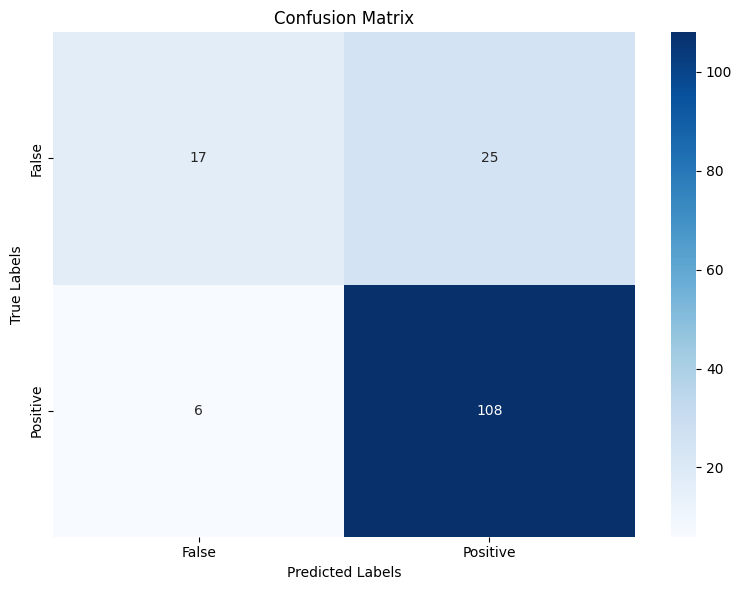

Test Error: 
 Accuracy: 80.1%

val Error: 
 Accuracy: 91.0%, Avg loss: 0.397165 

Done!


In [24]:
# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.001
#batch_size = 64 Note: this was determined when we loaded the data previously
num_epochs = 100

model = NN(input_size=input_size, num_classes=num_classes).to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
for index, (data,label) in enumerate(train_loader):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")


step=0
# epoch_loss=[]
best_val_acc=0.0
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    val(val_loader, model, loss_fn)

print(f"Best val_accuracy after training={best_val_acc} ")
model.load_state_dict(torch.load("best_model_weights.pth"))
test(test_loader,model)
val(val_loader, model, loss_fn)
writer.close()
print("Done!")

# CNN

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=2, bias=True)
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Val: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Val'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Failed to d

100%|██████████| 9/9 [00:00<00:00, 59.35it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.621357 

New best model saved with accuracy: 0.7308
Epoch 2
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 72.29it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.622692 

Epoch 3
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 71.01it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.603174 

Epoch 4
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 72.80it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.592104 

Epoch 5
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 73.33it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.580473 

Epoch 6
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 80.22it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.551429 

Epoch 7
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 76.14it/s]


val Error: 
 Accuracy: 74.4%, Avg loss: 0.544840 

New best model saved with accuracy: 0.7436
Epoch 8
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 92.53it/s]


val Error: 
 Accuracy: 74.4%, Avg loss: 0.514772 

Epoch 9
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.76it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.545095 

New best model saved with accuracy: 0.7564
Epoch 10
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.15it/s]


val Error: 
 Accuracy: 74.4%, Avg loss: 0.501771 

Epoch 11
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.26it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.506023 

New best model saved with accuracy: 0.7692
Epoch 12
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.68it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.485212 

Epoch 13
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.27it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.485722 

Epoch 14
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.52it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.469336 

Epoch 15
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 108.51it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.462256 

Epoch 16
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.65it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.458656 

New best model saved with accuracy: 0.8077
Epoch 17
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.61it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.447996 

Epoch 18
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.86it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.452526 

New best model saved with accuracy: 0.8205
Epoch 19
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.77it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.432991 

Epoch 20
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.21it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.426230 

Epoch 21
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.89it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.420312 

Epoch 22
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.55it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.418965 

Epoch 23
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.98it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.408171 

Epoch 24
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 95.13it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.401274 

New best model saved with accuracy: 0.8333
Epoch 25
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 81.42it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.411646 

Epoch 26
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 81.15it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.392198 

New best model saved with accuracy: 0.8462
Epoch 27
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 87.17it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.405396 

Epoch 28
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.33it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.412476 

Epoch 29
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 101.21it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.384137 

Epoch 30
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.49it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.381974 

Epoch 31
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 89.73it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.447503 

Epoch 32
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.90it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.409105 

Epoch 33
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.76it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.398346 

Epoch 34
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 92.88it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.379422 

Epoch 35
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 94.62it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.452344 

Epoch 36
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.28it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.381033 

Epoch 37
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.56it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.385959 

Epoch 38
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 83.87it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.368800 

New best model saved with accuracy: 0.8590
Epoch 39
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.09it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.362339 

New best model saved with accuracy: 0.8718
Epoch 40
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.16it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.369359 

Epoch 41
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.41it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.359028 

Epoch 42
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.60it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.357072 

Epoch 43
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 77.94it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.356827 

Epoch 44
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 68.74it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.361741 

Epoch 45
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 67.17it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.353295 

Epoch 46
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 69.38it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.352823 

Epoch 47
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 75.32it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.349730 

Epoch 48
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.25it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.349411 

Epoch 49
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 76.82it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.348194 

Epoch 50
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 98.66it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.351639 

Epoch 51
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.64it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.347179 

Epoch 52
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.11it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.409055 

Epoch 53
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.24it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.347488 

New best model saved with accuracy: 0.8846
Epoch 54
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.40it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.345971 

Epoch 55
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.88it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.350723 

Epoch 56
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.64it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.354328 

Epoch 57
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.55it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.349637 

Epoch 58
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 102.05it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.357386 

Epoch 59
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.17it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.342973 

Epoch 60
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 86.79it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.368657 

Epoch 61
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.14it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.360965 

Epoch 62
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 95.60it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.355150 

Epoch 63
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.58it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.342925 

New best model saved with accuracy: 0.8974
Epoch 64
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.62it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.341239 

Epoch 65
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 68.88it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.346820 

Epoch 66
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 75.61it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.342013 

Epoch 67
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 82.00it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.342024 

Epoch 68
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 119.41it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.338717 

Epoch 69
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.61it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.339610 

Epoch 70
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.08it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.344339 

Epoch 71
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 104.41it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.350476 

Epoch 72
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 103.63it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.338462 

Epoch 73
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.93it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.400051 

Epoch 74
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 84.58it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.355902 

Epoch 75
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.09it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.346075 

Epoch 76
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 89.74it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.341527 

Epoch 77
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.13it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.340783 

Epoch 78
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.00it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.338815 

Epoch 79
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 93.76it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.359254 

Epoch 80
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 90.24it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.339827 

Epoch 81
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 91.77it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.340028 

Epoch 82
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 100.79it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.353222 

Epoch 83
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 106.58it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.339521 

Epoch 84
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 92.53it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.345235 

Epoch 85
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 75.79it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.341238 

Epoch 86
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 72.13it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.340252 

Epoch 87
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 76.01it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.342910 

Epoch 88
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.24it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.336689 

Epoch 89
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 105.65it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.365101 

Epoch 90
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 86.70it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.339364 

Epoch 91
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 94.41it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.339681 

Epoch 92
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 88.85it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.339472 

Epoch 93
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 111.55it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.339764 

Epoch 94
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 87.94it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.339685 

Epoch 95
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 88.47it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.335796 

Epoch 96
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.01it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.341669 

Epoch 97
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 99.31it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.340100 

Epoch 98
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 94.06it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.337784 

Epoch 99
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 96.66it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.349123 

Epoch 100
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 97.05it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_22512\3915727614.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

val Error: 
 Accuracy: 85.9%, Avg loss: 0.337440 

Best val_accuracy after training=0.8974358974358975 


C:\Users\User\AppData\Local\Temp\ipykernel_22512\3990433603.py:287: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


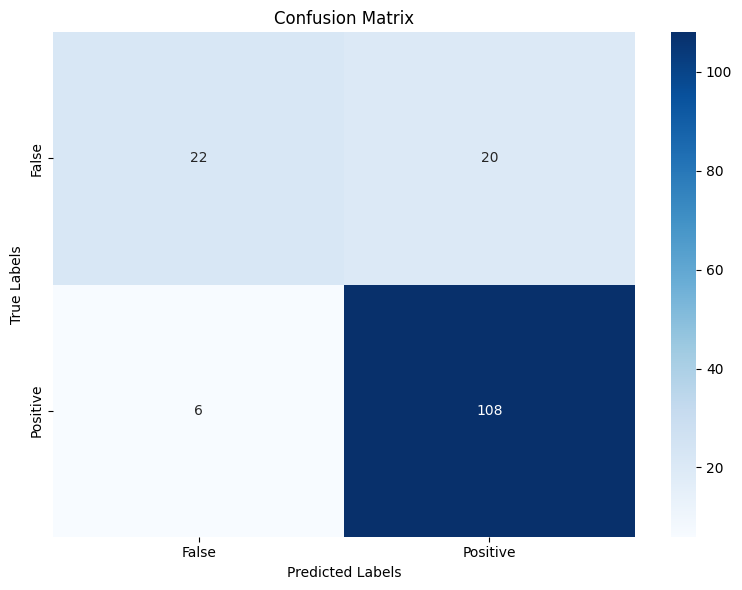

Test Error: 
 Accuracy: 83.3%

val Error: 
 Accuracy: 89.7%, Avg loss: 0.342925 

Done!


In [23]:
# Full implementation

# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.005
batch_size = 64
num_epochs = 100

model = CNN().to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
# for index, (data,label) in enumerate(train_loader):
#     data,label=train_data[index]
#     writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")


step=0
# epoch_loss=[]
best_val_acc=0.0
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    val(val_loader, model, loss_fn)

print(f"Best val_accuracy after training={best_val_acc} ")
model.load_state_dict(torch.load("best_model_weights.pth"))
test(test_loader,model)
val(val_loader, model, loss_fn)
writer.close()
print("Done!")

# Pretained Model RESNET 18

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 9/9 [00:00<00:00, 21.15it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 1.111047 

New best model saved with accuracy: 0.7308
Epoch 2
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.48it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.851587 

Epoch 3
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.71it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.712609 

Epoch 4
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.98it/s]


val Error: 
 Accuracy: 75.6%, Avg loss: 0.701940 

New best model saved with accuracy: 0.7564
Epoch 5
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.88it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.546688 

New best model saved with accuracy: 0.7949
Epoch 6
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.29it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.347566 

New best model saved with accuracy: 0.8333
Epoch 7
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.88it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.530707 

Epoch 8
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.08it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.329151 

New best model saved with accuracy: 0.8590
Epoch 9
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.38it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.323581 

Epoch 10
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.11it/s]


val Error: 
 Accuracy: 71.8%, Avg loss: 1.066679 

Epoch 11
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.27it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.669298 

Epoch 12
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.429950 

Epoch 13
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.50it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.600715 

New best model saved with accuracy: 0.8718
Epoch 14
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.81it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.692539 

Epoch 15
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.37it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.861129 

Epoch 16
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.97it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.932228 

Epoch 17
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.01it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.794065 

Epoch 18
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.39it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.621121 

Epoch 19
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.00it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.717331 

Epoch 20
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.87it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.858439 

Epoch 21
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.67it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.397585 

Epoch 22
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.46it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.644176 

Epoch 23
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.90it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.569643 

Epoch 24
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.44it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.429253 

Epoch 25
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.29it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 1.055686 

Epoch 26
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.22it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.953754 

Epoch 27
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.17it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.456646 

Epoch 28
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.71it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.744173 

Epoch 29
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.83it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.441503 

Epoch 30
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.42it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.292522 

New best model saved with accuracy: 0.8974
Epoch 31
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.455895 

Epoch 32
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.11it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.568523 

Epoch 33
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.75it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.554400 

Epoch 34
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.54it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.593598 

Epoch 35
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.24it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.719749 

Epoch 36
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.769748 

Epoch 37
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.57it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.682922 

Epoch 38
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.16it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.424212 

New best model saved with accuracy: 0.9103
Epoch 39
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.16it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.617776 

Epoch 40
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.55it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.436535 

Epoch 41
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.543775 

Epoch 42
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.515780 

Epoch 43
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.49it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.566655 

Epoch 44
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.24it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.638890 

Epoch 45
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.552767 

Epoch 46
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.79it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.737494 

Epoch 47
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.90it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 1.023624 

Epoch 48
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.34it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.894545 

Epoch 49
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.00it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.681828 

Epoch 50
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.564680 

Epoch 51
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.62it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.665305 

Epoch 52
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.51it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.480637 

Epoch 53
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.30it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.454537 

Epoch 54
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.48it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.569217 

Epoch 55
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.71it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.719738 

Epoch 56
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.21it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.374431 

Epoch 57
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.27it/s]


val Error: 
 Accuracy: 92.3%, Avg loss: 0.413744 

New best model saved with accuracy: 0.9231
Epoch 58
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.04it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.441248 

Epoch 59
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.498105 

Epoch 60
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.24it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.453939 

Epoch 61
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.34it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.648530 

Epoch 62
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.03it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.374657 

Epoch 63
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.15it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.381320 

Epoch 64
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.32it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.449430 

Epoch 65
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.83it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.398774 

Epoch 66
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.49it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.810949 

Epoch 67
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.29it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.548120 

Epoch 68
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.84it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.518358 

Epoch 69
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.555499 

Epoch 70
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.82it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.454503 

Epoch 71
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.96it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.465548 

Epoch 72
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.89it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.852596 

Epoch 73
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.98it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.739302 

Epoch 74
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.95it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.644421 

Epoch 75
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.09it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.714333 

Epoch 76
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.31it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.649231 

Epoch 77
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.81it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.910517 

Epoch 78
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.45it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.524316 

Epoch 79
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.43it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.691613 

Epoch 80
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.11it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.555782 

Epoch 81
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.03it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.469522 

Epoch 82
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.48it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.499762 

Epoch 83
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.60it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.600632 

Epoch 84
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.80it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.813305 

Epoch 85
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.05it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.681735 

Epoch 86
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.07it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.692963 

Epoch 87
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.91it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.682628 

Epoch 88
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.42it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.659699 

Epoch 89
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.590317 

Epoch 90
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.98it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.558007 

Epoch 91
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.20it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.557137 

Epoch 92
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.39it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.591435 

Epoch 93
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.77it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.598679 

Epoch 94
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.13it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.609217 

Epoch 95
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.86it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.606679 

Epoch 96
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.35it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.602881 

Epoch 97
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 23.62it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.603436 

Epoch 98
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.61it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.611462 

Epoch 99
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.46it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.613559 

Epoch 100
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 24.81it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_12236\3594226377.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

val Error: 
 Accuracy: 91.0%, Avg loss: 0.606814 

Best val_accuracy after training=0.9230769230769231 


C:\Users\User\AppData\Local\Temp\ipykernel_12236\464863941.py:289: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


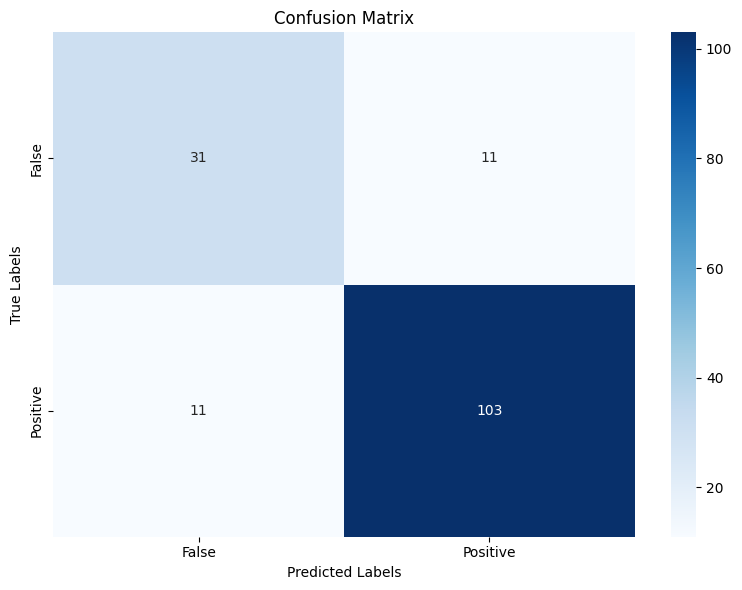

Test Error: 
 Accuracy: 85.9%

val Error: 
 Accuracy: 92.3%, Avg loss: 0.413744 

Done!


In [10]:
# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.001
num_epochs = 100


model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# # Freeze the model
# for param in model.parameters():
#     param.requires_grad=False

model.conv1 = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)

# # Optionally copy pretrained weights and average across RGB channels
# with torch.no_grad():
#     pretrained_weights = model.conv1.weight  # Original weights for RGB
#     model.conv1.weight.copy_(torch.mean(pretrained_weights, dim=1, keepdim=True))



# Adjust the fully connected layer to match the number of output classes
num_classes = 2  # Example: MNIST has 10 classes
# model.fc = nn.Sequential(
#             nn.Linear(25088, 100),
#             nn.ReLU(),
#             nn.Linear(100, 2),
# )
# model.avgpool = nn.Identity()

model.fc = nn.Linear(512, 2)
print(model)

## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to the correct device
model = model.to(device)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
for index, (data,label) in enumerate(train_loader):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")


step=0
# epoch_loss=[]
best_val_acc=0.0
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    val(val_loader, model, loss_fn)

print(f"Best val_accuracy after training={best_val_acc} ")
model.load_state_dict(torch.load("best_model_weights.pth"))
test(test_loader,model)
val(val_loader, model, loss_fn)
writer.close()
print("Done!")

# Alexnet pretrained model

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bi

100%|██████████| 9/9 [00:00<00:00, 16.79it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.594993 

New best model saved with accuracy: 0.7308
Epoch 2
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.68it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.649823 

Epoch 3
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.95it/s]


val Error: 
 Accuracy: 74.4%, Avg loss: 0.549047 

New best model saved with accuracy: 0.7436
Epoch 4
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.79it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.580678 

Epoch 5
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.95it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.498916 

New best model saved with accuracy: 0.7692
Epoch 6
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.56it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.456625 

New best model saved with accuracy: 0.7821
Epoch 7
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.80it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.445505 

New best model saved with accuracy: 0.8077
Epoch 8
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.82it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.426255 

New best model saved with accuracy: 0.8333
Epoch 9
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.69it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.370279 

New best model saved with accuracy: 0.8462
Epoch 10
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.11it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.339451 

New best model saved with accuracy: 0.8590
Epoch 11
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.58it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.356115 

Epoch 12
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.76it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.362705 

Epoch 13
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.379685 

Epoch 14
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.05it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.291056 

New best model saved with accuracy: 0.8718
Epoch 15
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.82it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.457760 

Epoch 16
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.74it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.533700 

Epoch 17
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.64it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.319641 

Epoch 18
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.648071 

Epoch 19
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.84it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.368734 

Epoch 20
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.529795 

Epoch 21
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.86it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.497072 

Epoch 22
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.94it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.299121 

New best model saved with accuracy: 0.9103
Epoch 23
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


val Error: 
 Accuracy: 93.6%, Avg loss: 0.302771 

New best model saved with accuracy: 0.9359
Epoch 24
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.66it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.381505 

Epoch 25
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.08it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.318919 

Epoch 26
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.07it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.277514 

Epoch 27
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.97it/s]


val Error: 
 Accuracy: 82.1%, Avg loss: 0.549341 

Epoch 28
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.09it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.466671 

Epoch 29
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.02it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.350286 

Epoch 30
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


val Error: 
 Accuracy: 73.1%, Avg loss: 0.467836 

Epoch 31
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.04it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.340337 

Epoch 32
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.89it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.519280 

Epoch 33
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.86it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.321088 

Epoch 34
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.97it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 0.514536 

Epoch 35
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.94it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.268461 

Epoch 36
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.84it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.378055 

Epoch 37
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.81it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.334970 

Epoch 38
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.88it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.356973 

Epoch 39
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.308746 

Epoch 40
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.93it/s]


val Error: 
 Accuracy: 79.5%, Avg loss: 0.468898 

Epoch 41
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.06it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.241941 

Epoch 42
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.243606 

Epoch 43
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.07it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.329543 

Epoch 44
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.88it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.272133 

Epoch 45
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.07it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.299386 

Epoch 46
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.78it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.300775 

Epoch 47
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.368912 

Epoch 48
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.82it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.295375 

Epoch 49
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.78it/s]


val Error: 
 Accuracy: 92.3%, Avg loss: 0.362124 

Epoch 50
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.80it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.509006 

Epoch 51
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.247457 

Epoch 52
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.05it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.279612 

Epoch 53
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.96it/s]


val Error: 
 Accuracy: 92.3%, Avg loss: 0.504807 

Epoch 54
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.86it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.588806 

Epoch 55
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.81it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.909125 

Epoch 56
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.96it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.787046 

Epoch 57
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


val Error: 
 Accuracy: 76.9%, Avg loss: 0.548480 

Epoch 58
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.433263 

Epoch 59
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.72it/s]


val Error: 
 Accuracy: 80.8%, Avg loss: 0.452660 

Epoch 60
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.08it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.405712 

Epoch 61
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.86it/s]


val Error: 
 Accuracy: 84.6%, Avg loss: 0.465695 

Epoch 62
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.81it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.305188 

Epoch 63
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.86it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.275349 

Epoch 64
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.08it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.394416 

Epoch 65
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.96it/s]


val Error: 
 Accuracy: 78.2%, Avg loss: 0.497284 

Epoch 66
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.90it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.381684 

Epoch 67
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.74it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.293563 

Epoch 68
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.73it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.345211 

Epoch 69
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.79it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.278207 

Epoch 70
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.84it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.387568 

Epoch 71
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.81it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.239403 

Epoch 72
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.76it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.266416 

Epoch 73
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.289860 

Epoch 74
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.81it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.272031 

Epoch 75
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.588031 

Epoch 76
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.71it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.377658 

Epoch 77
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.435660 

Epoch 78
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.92it/s]


val Error: 
 Accuracy: 92.3%, Avg loss: 0.341866 

Epoch 79
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.336009 

Epoch 80
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.55it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.377207 

Epoch 81
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.79it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.403362 

Epoch 82
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.78it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.460196 

Epoch 83
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.78it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.752603 

Epoch 84
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.761873 

Epoch 85
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.89it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.719961 

Epoch 86
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.98it/s]


val Error: 
 Accuracy: 92.3%, Avg loss: 0.728280 

Epoch 87
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.03it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 0.570214 

Epoch 88
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.78it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.567874 

Epoch 89
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.94it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.757191 

Epoch 90
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.83it/s]


val Error: 
 Accuracy: 89.7%, Avg loss: 0.896651 

Epoch 91
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.03it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 1.020058 

Epoch 92
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.99it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.873828 

Epoch 93
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.06it/s]


val Error: 
 Accuracy: 91.0%, Avg loss: 0.753598 

Epoch 94
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 18.00it/s]


val Error: 
 Accuracy: 87.2%, Avg loss: 1.200291 

Epoch 95
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.97it/s]


val Error: 
 Accuracy: 83.3%, Avg loss: 1.740403 

Epoch 96
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.79it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.968312 

Epoch 97
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.81it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 0.686207 

Epoch 98
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.75it/s]


val Error: 
 Accuracy: 85.9%, Avg loss: 0.960880 

Epoch 99
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.83it/s]


val Error: 
 Accuracy: 88.5%, Avg loss: 1.613860 

Epoch 100
-------------------------------


100%|██████████| 9/9 [00:00<00:00, 17.74it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_17440\782466378.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

val Error: 
 Accuracy: 88.5%, Avg loss: 1.149735 

Best val_accuracy after training=0.9358974358974359 


C:\Users\User\AppData\Local\Temp\ipykernel_17440\3990433603.py:287: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


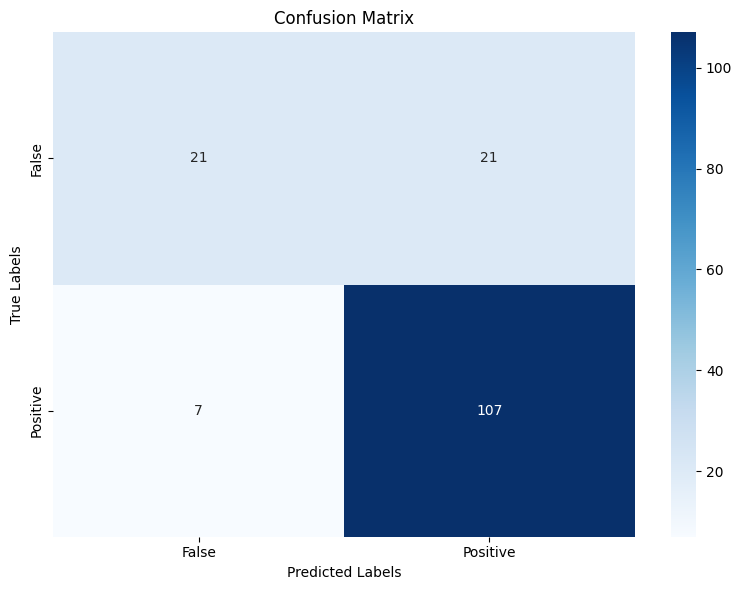

Test Error: 
 Accuracy: 82.1%

val Error: 
 Accuracy: 93.6%, Avg loss: 0.302771 

Done!


In [8]:
# Hyperparameters
num_epochs = 100

#impoert model

model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

# # Freeze the model
# for param in model.parameters():
#     param.requires_grad=False

# # Unfreeze the classifier parameters
# for param in model.classifier.parameters():
#     param.requires_grad = True

#Change input layer to fit grayscale images
model.features[0] = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(1, 1),
    padding=(1, 1),
    bias=False
)

#Change output layer to fit two classes
model.classifier[6] = nn.Linear(4096, 2)

#Print model architechture
print(model)


## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to the correct device
model = model.to(device)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

#show using dataset on tensorboard
for index, (data,label) in enumerate(train_loader):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")


step=0
# epoch_loss=[]
best_val_acc=0.0
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    val(val_loader, model, loss_fn)

print(f"Best val_accuracy after training={best_val_acc} ")
model.load_state_dict(torch.load("best_model_weights.pth"))
test(test_loader,model)
val(val_loader, model, loss_fn)
writer.close()
print("Done!")


# Save current model with results

In [121]:

modelname="R18_E&E"

try:
    os.mkdir(f"Saved_models/{modelname}") # Will not create parent folders, unlike os.makedirs()
    print(f"Folder created successfully")
except OSError as e:
    print(f"Error creating folder: {e}")    
tensorpath="runs\DisplayImage"
copy_directory(tensorpath,f"Saved_models/{modelname}")

# 7. Save entire model (Less recommended).
save_entire_model_path = f"Saved_models/{modelname}/{modelname}.pth"
torch.save(model, save_entire_model_path)
print(f"Entire model saved to: {save_entire_model_path}")




Error creating folder: [WinError 183] Cannot create a file when that file already exists: 'Saved_models/R18_E&E'
An unexpected error occurred: [WinError 183] Cannot create a file when that file already exists: 'Saved_models/R18_E&E\\DisplayImage'
Entire model saved to: Saved_models/R18_E&E/R18_E&E.pth


In [85]:

# 8. Load entire model
loaded_entire_model = torch.load(f"Saved_models/{modelname}/simple_model_entire.pth")
loaded_entire_model = loaded_entire_model.to(device)
loaded_entire_model.eval()
print("Entire model loaded successfully!")


Entire model loaded successfully!


C:\Users\User\AppData\Local\Temp\ipykernel_3756\150428221.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_entire_model = torch.load(f"Saved_models/{modelname}/sim

In [6]:
import os
import shutil

def clear_folder(folder_path):
    """
    Deletes all contents of the specified folder.

    :param folder_path: Path to the folder whose contents need to be deleted
    """
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return

    # Iterate through each item in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        try:
            # Check if it's a file or folder and delete accordingly
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)  # Delete files or symbolic links
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)  # Delete directories
            print(f"Deleted: {item_path}")
        except Exception as e:
            print(f"Failed to delete {item_path}. Reason: {e}")


clear_folder(folder)

Failed to delete runs/DisplayImage\New folder. Reason: [WinError 5] Access is denied: 'runs/DisplayImage\\New folder'


In [1]:
import os
import shutil
# Specify the folder to delete
folder_name = "runs"

# Delete the folder and its contents
try:
    shutil.rmtree(folder_name)  # Removes the folder and all its contents
    print(f"Folder '{folder_name}' and its contents deleted successfully!")
except FileNotFoundError:
    print(f"Folder '{folder_name}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: [WinError 5] Access is denied: 'runs\\DisplayImage\\New folder'


# Pretrained Graveyard

In [19]:
# test= torchvision.models.vgg16(weights="DEFAULT")
# test.features[0] = nn.Conv2d(
#     in_channels=1,  # Change to 1 channel for grayscale
#     out_channels=64,
#     kernel_size=(7, 7),
#     stride=(1, 1),
#     padding=(1, 1),
#     bias=False
# )


# # Adjust the fully connected layer to match the number of output classes
# num_classes = 2  # Example: MNIST has 10 classes
# test.classifier = nn.Sequential(
#             nn.Linear(512, 100),
#             nn.ReLU(),
#             nn.Linear(100, 2),
# )
# test.avgpool = nn.Identity()

# print(test)
# x=torch.randn(20,1,64,64)
# print(test(x).shape)


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\MLS_CW\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.features[0] = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(1, 1),
    padding=(1, 1),
    bias=False
)


# Adjust the fully connected layer to match the number of output classes
num_classes = 2  # Example: MNIST has 10 classes
model.classifier = nn.Sequential(
            nn.Linear(9216, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
)
model.avgpool = nn.Identity()

print(model)
x=torch.randn(20,1,64,64)
print(model(x).shape)

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): Identity()
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_featu

In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.features[0] = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(1, 1),
    padding=(1, 1),
    bias=False
)
model.classifier[6] = nn.Linear(4096, 2)
print(model)
x=torch.randn(20,1,28,28)
print(model(x).shape)

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bi

In [13]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.conv1 = nn.Conv2d(
    in_channels=1,  # Change to 1 channel for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)

model.fc = nn.Linear(512, 2)
print(model)
x=torch.randn(20,1,28,28)
print(model(x).shape)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0
